# Localization Loss



In [1]:
import tensorflow as tf

In [2]:
%load_ext autoreload
%autoreload 2

import sys
 
# setting path
sys.path.append('../read_data/')
sys.path.append('../')

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import cv2

In [4]:
# Assuse we have a 8 x 8 box divided into 2 x 2 prior boxes

image_size = 32
boxes = []
prior_boxes = []
default_box_size  = 4

for i in range(0, image_size // default_box_size,):
    for j in range(0, image_size // default_box_size):
        boxes.append([ j * default_box_size, i * default_box_size, 
                            (j + 1) * default_box_size, (i + 1) * default_box_size ])
        prior_boxes.append( [ j * default_box_size + default_box_size // 2, i * default_box_size + default_box_size // 2, default_box_size, default_box_size ] )
        
# gt_boxes = [6, 6, 14, 13]
# gt_boxes = [[4, 4, 9, 9], [9, 9, 14 , 14], [24, 24, 29, 29]]

# boxes with IOU < 0.5
gt_boxes = [[4, 4, 11, 11], [9, 9, 14 , 14], [24, 24, 31, 31]]

In [5]:
prior_boxes[54]

[26, 26, 4, 4]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


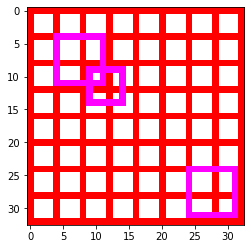

In [6]:
image = np.ones((image_size + 1, image_size + 1, 3))

for box in boxes:
    
    start_x, start_y, end_x, end_y = box
    
    image = cv2.rectangle(image, [start_x, start_y], [end_x, end_y], (255, 0 , 0), thickness = 1)

for box in gt_boxes:
    
    start_x, start_y, end_x, end_y = box  
    image = cv2.rectangle(image, [start_x, start_y], [end_x, end_y], (255, 0, 255), thickness = 1)

plt.imshow(image)

In [7]:
boxes = np.array(boxes, np.float32) / image_size
prior_boxes = np.array(prior_boxes, np.float32) / image_size
gt_boxes = np.array([gt_boxes], np.float32) / image_size
gt_labels = [1, 2, 1]

In [8]:
gt_boxes

array([[[0.125  , 0.125  , 0.34375, 0.34375],
        [0.28125, 0.28125, 0.4375 , 0.4375 ],
        [0.75   , 0.75   , 0.96875, 0.96875]]], dtype=float32)

In [9]:
print(prior_boxes.shape)
print(boxes.shape)
print(gt_boxes.shape)

(64, 4)
(64, 4)
(1, 3, 4)


In [10]:
from bbox_utils import box_overlap_iou, convert_to_centre_dimensions_form, calculate_offset_from_gt

In [11]:
box_x_min, box_y_min, box_x_max, box_y_max = tf.split(boxes, 4, axis = 1)
gt_boxes_x_min, gt_boxes_y_min, gt_boxes_x_max, gt_boxes_y_max = tf.split(gt_boxes, 4, axis = 2)

intersection_x_min = tf.maximum(box_x_min, tf.transpose(gt_boxes_x_min, perm=[0, 2, 1]))
intersection_y_min = tf.maximum(box_y_min, tf.transpose(gt_boxes_y_min, perm=[0, 2, 1]))

intersection_x_max = tf.minimum(box_x_max, tf.transpose(gt_boxes_x_max, perm=[0, 2, 1]))
intersection_y_max = tf.minimum(box_y_max, tf.transpose(gt_boxes_y_max, perm=[0, 2, 1]))

# need to take care of boxes that don't overlap at all
intersection_area = tf.maximum(intersection_x_max - intersection_x_min, 0) * tf.maximum(intersection_y_max - intersection_y_min, 0)

boxes_areas = (box_x_max - box_x_min) * (box_y_max - box_y_min)
gt_box_areas = (gt_boxes_x_max - gt_boxes_x_min) * (gt_boxes_y_max - gt_boxes_y_min)

union = (boxes_areas + tf.transpose(gt_box_areas, perm=[0, 2, 1])) - intersection_area

2022-09-04 17:44:26.004185: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
# union

In [13]:
threshold = 0.5
number_of_labels = 3

In [14]:
# number of rows for the IOU map the is the number of gt_boxes
IOU_map = box_overlap_iou(boxes, gt_boxes)

# convert ground boxes labels to box label format
gt_box_label = convert_to_centre_dimensions_form(gt_boxes)

# select the box with the highest IOU
highest_overlap_idx = tf.math.argmax(IOU_map, axis = 1)
highest_overlap_idx = tf.cast(highest_overlap_idx, tf.int32)
idx = tf.range(IOU_map.shape[1])
highest_overlap_idx_map = tf.expand_dims(tf.equal(idx, tf.transpose(highest_overlap_idx)), axis = 0)
IOU_map = tf.where(tf.transpose(highest_overlap_idx_map, perm=[0,2,1]), tf.constant(1.0), IOU_map)

# find the column idx with the highest IOU at each row
max_IOU_idx_per_row = tf.math.argmax(IOU_map, axis = 2)
# find the max value per row
max_IOU_per_row = tf.reduce_max(IOU_map, axis = 2)

# threshold IOU
max_IOU_above_threshold = tf.greater(max_IOU_per_row, threshold)

# map the gt boxes to the prior boxes with the highest overlap
gt_box_label_map = tf.gather(gt_box_label, max_IOU_idx_per_row, batch_dims = 1)
# get the offset, offcet (delta_cx, delta_cy, delta_width, delta_height)
gt_box_label_map_offsets = calculate_offset_from_gt(gt_box_label_map, prior_boxes)
# remove from gt_boxes_map where overlap with prior boxes is less than 0.5
gt_boxes_map_offset_suppressed = tf.where( tf.expand_dims(max_IOU_above_threshold, -1),  
                                    gt_box_label_map_offsets, tf.zeros_like(gt_box_label_map))
# add a positive condition column for the localization loss
max_IOU_above_threshold_expand = tf.expand_dims(max_IOU_above_threshold, -1)
max_IOU_above_threshold_expand = tf.cast(max_IOU_above_threshold_expand, tf.float32)
gt_boxes_map_offset_suppressed_with_pos_cond = tf.concat([  gt_boxes_map_offset_suppressed, 
                                                            max_IOU_above_threshold_expand ], axis = 2)

gt_labels_map = tf.gather(gt_labels, max_IOU_idx_per_row, batch_dims = 0)
# suppress the label where IOU with the gt boxes is < 0.5
gt_labels_map_suppressed = tf.where( max_IOU_above_threshold, 
                                    gt_labels_map, tf.zeros_like(gt_labels_map))
gt_labels_one_hot_encoded = tf.one_hot(gt_labels_map_suppressed, number_of_labels)

In [15]:
gt_labels_map_suppressed

<tf.Tensor: shape=(1, 64), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int32)>

In [16]:
highest_overlap_idx = tf.math.argmax(IOU_map, axis = 1)
highest_overlap_idx = tf.cast(highest_overlap_idx, tf.int32)

highest_overlap_idx

<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[ 9, 18, 54]], dtype=int32)>

In [17]:
max_IOU_above_threshold = tf.greater(max_IOU_per_row, threshold)
idx = tf.range(IOU_map.shape[1])
highest_overlap_idx_map = tf.expand_dims(tf.equal(idx, tf.transpose(highest_overlap_idx)), axis = 0)
IOU_map = tf.where(tf.transpose(highest_overlap_idx_map, perm=[0,2,1]), tf.constant(1.0), IOU_map)

In [18]:
tf.transpose(highest_overlap_idx_map, perm=[0,2,1])

<tf.Tensor: shape=(1, 64, 3), dtype=bool, numpy=
array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        [False, False, False],
        [False, False, False],
        [False, False, False],
        [False, False, False],
        [False, False, False],
        [False, False, False],
        [ True, False, False],
        [False, False, False],
        [False, False, False],
        [False, False, False],
        [False, False, False],
        [False, False, False],
        [False, False, False],
        [False, False, False],
        [False, False, False],
        [False,  True, False],
        [False, False, False],
        [False, False, False],
        [False, False, False],
        [False, False, False],
        [False, False, False],
        [False, False, False],
        [False, False, False],
        [False, False, False],
        [False, False, False],
        [False, False, False],
        [False, False, False],
        [False, False

In [19]:
idx = tf.range(IOU_map.shape[1])
tf.expand_dims(tf.equal(idx, tf.transpose(highest_overlap_idx)), axis = 0)

<tf.Tensor: shape=(1, 3, 64), dtype=bool, numpy=
array([[[False, False, False, False, False, False, False, False, False,
          True, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False],
        [False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
          True, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False

In [20]:
highest_overlap_idx = tf.math.argmax(IOU_map, axis = 1)

highest_overlap_idx = tf.cast(highest_overlap_idx, tf.int32)

In [21]:
highest_overlap_idx

<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[ 9, 18, 54]], dtype=int32)>

In [22]:
tf.not_equal(highest_overlap_idx, tf.constant(0))

<tf.Tensor: shape=(1, 3), dtype=bool, numpy=array([[ True,  True,  True]])>

In [23]:
gt_box_label_map[0, 0, :]

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.234375, 0.234375, 0.21875 , 0.21875 ], dtype=float32)>

In [24]:
prior_boxes_testing = tf.expand_dims(prior_boxes, axis=0)
# (gt_box_label_map[:, :, 0] - prior_boxes_testing[:, :, 0]) / prior_boxes_testing[:, :, 0]

g_j_cx = (gt_box_label_map[:, :, 0] - prior_boxes_testing[:, :, 0]) / prior_boxes_testing[:, :, 2]
g_j_cy = (gt_box_label_map[:, :, 1] - prior_boxes_testing[:, :, 1]) / prior_boxes_testing[:, :, 3]
g_j_w = tf.math.log(gt_box_label_map[:, :, 2] / prior_boxes_testing[:, :, 2])
g_j_h = tf.math.log(gt_box_label_map[:, :, 3] / prior_boxes_testing[:, :, 3])

offset = tf.concat( [ g_j_cx, g_j_cy, g_j_w, g_j_h ] , axis = 0)

In [25]:
print(gt_box_label_map[0, 54])
print(prior_boxes_testing[0, 54])
(gt_box_label_map[0, 54] - prior_boxes_testing[0, 54]) #/ prior_boxes_testing[0, 54]

tf.Tensor([0.859375 0.859375 0.21875  0.21875 ], shape=(4,), dtype=float32)
tf.Tensor([0.8125 0.8125 0.125  0.125 ], shape=(4,), dtype=float32)


<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.046875, 0.046875, 0.09375 , 0.09375 ], dtype=float32)>

In [26]:
prior_boxes_testing[0, 54]

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.8125, 0.8125, 0.125 , 0.125 ], dtype=float32)>

In [27]:
print(g_j_cx[0, 54])
print(g_j_cy[0, 54])
print(g_j_w[0, 54])
print(g_j_h[0, 54])
# offset[0, 54]

tf.Tensor(0.375, shape=(), dtype=float32)
tf.Tensor(0.375, shape=(), dtype=float32)
tf.Tensor(0.5596158, shape=(), dtype=float32)
tf.Tensor(0.5596158, shape=(), dtype=float32)


In [28]:
tf.transpose(tf.expand_dims(offset, axis = 0), perm=[0,2,1])

<tf.Tensor: shape=(1, 64, 4), dtype=float32, numpy=
array([[[ 1.375     ,  1.375     ,  0.5596158 ,  0.5596158 ],
        [ 0.375     ,  1.375     ,  0.5596158 ,  0.5596158 ],
        [-0.625     ,  1.375     ,  0.5596158 ,  0.5596158 ],
        [-1.625     ,  1.375     ,  0.5596158 ,  0.5596158 ],
        [-2.625     ,  1.375     ,  0.5596158 ,  0.5596158 ],
        [-3.625     ,  1.375     ,  0.5596158 ,  0.5596158 ],
        [-4.625     ,  1.375     ,  0.5596158 ,  0.5596158 ],
        [-5.625     ,  1.375     ,  0.5596158 ,  0.5596158 ],
        [ 1.375     ,  0.375     ,  0.5596158 ,  0.5596158 ],
        [ 0.375     ,  0.375     ,  0.5596158 ,  0.5596158 ],
        [-0.625     ,  0.375     ,  0.5596158 ,  0.5596158 ],
        [-1.625     ,  0.375     ,  0.5596158 ,  0.5596158 ],
        [-2.625     ,  0.375     ,  0.5596158 ,  0.5596158 ],
        [-3.625     ,  0.375     ,  0.5596158 ,  0.5596158 ],
        [-4.625     ,  0.375     ,  0.5596158 ,  0.5596158 ],
        [-5.625   

In [29]:
tf.transpose(tf.expand_dims(offset, axis = 0), perm=[0,2,1])

<tf.Tensor: shape=(1, 64, 4), dtype=float32, numpy=
array([[[ 1.375     ,  1.375     ,  0.5596158 ,  0.5596158 ],
        [ 0.375     ,  1.375     ,  0.5596158 ,  0.5596158 ],
        [-0.625     ,  1.375     ,  0.5596158 ,  0.5596158 ],
        [-1.625     ,  1.375     ,  0.5596158 ,  0.5596158 ],
        [-2.625     ,  1.375     ,  0.5596158 ,  0.5596158 ],
        [-3.625     ,  1.375     ,  0.5596158 ,  0.5596158 ],
        [-4.625     ,  1.375     ,  0.5596158 ,  0.5596158 ],
        [-5.625     ,  1.375     ,  0.5596158 ,  0.5596158 ],
        [ 1.375     ,  0.375     ,  0.5596158 ,  0.5596158 ],
        [ 0.375     ,  0.375     ,  0.5596158 ,  0.5596158 ],
        [-0.625     ,  0.375     ,  0.5596158 ,  0.5596158 ],
        [-1.625     ,  0.375     ,  0.5596158 ,  0.5596158 ],
        [-2.625     ,  0.375     ,  0.5596158 ,  0.5596158 ],
        [-3.625     ,  0.375     ,  0.5596158 ,  0.5596158 ],
        [-4.625     ,  0.375     ,  0.5596158 ,  0.5596158 ],
        [-5.625   

In [30]:
max_IOU_idx_per_row

<tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2]])>

In [31]:
gt_box_label_map

<tf.Tensor: shape=(1, 64, 4), dtype=float32, numpy=
array([[[0.234375, 0.234375, 0.21875 , 0.21875 ],
        [0.234375, 0.234375, 0.21875 , 0.21875 ],
        [0.234375, 0.234375, 0.21875 , 0.21875 ],
        [0.234375, 0.234375, 0.21875 , 0.21875 ],
        [0.234375, 0.234375, 0.21875 , 0.21875 ],
        [0.234375, 0.234375, 0.21875 , 0.21875 ],
        [0.234375, 0.234375, 0.21875 , 0.21875 ],
        [0.234375, 0.234375, 0.21875 , 0.21875 ],
        [0.234375, 0.234375, 0.21875 , 0.21875 ],
        [0.234375, 0.234375, 0.21875 , 0.21875 ],
        [0.234375, 0.234375, 0.21875 , 0.21875 ],
        [0.234375, 0.234375, 0.21875 , 0.21875 ],
        [0.234375, 0.234375, 0.21875 , 0.21875 ],
        [0.234375, 0.234375, 0.21875 , 0.21875 ],
        [0.234375, 0.234375, 0.21875 , 0.21875 ],
        [0.234375, 0.234375, 0.21875 , 0.21875 ],
        [0.234375, 0.234375, 0.21875 , 0.21875 ],
        [0.234375, 0.234375, 0.21875 , 0.21875 ],
        [0.359375, 0.359375, 0.15625 , 0.15625 ]

In [32]:
from bbox_utils import match_priors_with_gt, box_overlap_iou, convert_to_centre_dimensions_form

In [33]:
gt_labels

[1, 2, 1]

In [34]:
gt_boxes = [[4, 4, 9, 9], [9, 9, 14 , 14], [24, 24, 29, 29]]

# boxes with no 
gt_boxes = [[4, 4, 11, 11], [9, 9, 14 , 14], [24, 24, 31, 31]]
gt_labels = [1, 2, 1]

gt_boxes_normalized = tf.constant([gt_boxes], tf.float32) / image_size

gt_labels = tf.constant([gt_labels])

In [35]:
boxes[54]

array([0.75 , 0.75 , 0.875, 0.875], dtype=float32)

In [36]:
(0.875 + 0.75) / 2

0.8125

In [37]:
# gt_boxes center format 

# [[6.5, 6.5, 5, 5], [11.5, 11.5, 5 , 2.5], [26.5, 26.5, 5, 5]]
# [[0.203125, 0.203125, 0.15625, 0.15625], [0.359375, 0.359375, 0.15625, 0.15625], [0.828125, 0.828125, 0.15625, 0.15625]]

# default_boxes: [[6, 6, 4, 4], [None, None, None, None], [26, 26, 4, 4]]
# default_boxes: [[0.1875, 0.1875, 0.125, 0.125], [None, None, None, None], [0.8125 , 0.8125 , 0.125, 0.125]]

# g_val for loss: [[0.125, 0.125, 0.22314, 0.22314], [], [0.125, 0.125, 0.22314, 0.22314]]

In [38]:
0.828125 - 0.8125 

0.015625

In [39]:
(26.5 - 26) / 32

0.015625

In [40]:
boxes[9]

array([0.125, 0.125, 0.25 , 0.25 ], dtype=float32)

In [42]:
actual_deltas, actual_labels = match_priors_with_gt(prior_boxes, boxes, gt_boxes_normalized, gt_labels, 3)

In [43]:
np.random.seed(42)
pred_deltas = np.random.rand(1, 64, 4) * np.random.randint(-1, 2, size = (1, 64, 4))

In [44]:
pred_deltas[0, 9] = [-0.015, 0.012, 0 , -0.031]
pred_deltas[0, 54] = [0.15, 0.12, -0.0123 , -0.04]

In [45]:
huber_loss = tf.keras.losses.Huber(
    reduction=tf.keras.losses.Reduction.NONE
)

huber_loss([ [0.125, 0.125, 0.22314, 0.22314], [0.125, 0.125, 0.22314, 0.22314] ], 
            [[-0.015, 0.012, 0 , -0.031], [0.15, 0.12, -0.0123 , -0.04]] 
          ) / 2

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.00917172, 0.00783279], dtype=float32)>

In [46]:
from classification_loss import SSDLoss

In [47]:
pred_deltas

array([[[ 0.37454012,  0.        ,  0.        ,  0.59865848],
        [ 0.        ,  0.        ,  0.05808361,  0.        ],
        [ 0.60111501,  0.        ,  0.02058449,  0.96990985],
        [ 0.        ,  0.        ,  0.        , -0.18340451],
        [-0.30424224, -0.52475643,  0.43194502,  0.        ],
        [ 0.61185289, -0.13949386,  0.        ,  0.36636184],
        [ 0.        ,  0.78517596,  0.        , -0.51423444],
        [-0.59241457,  0.        ,  0.60754485, -0.17052412],
        [-0.06505159, -0.94888554,  0.        ,  0.        ],
        [-0.015     ,  0.012     ,  0.        , -0.031     ],
        [ 0.        ,  0.49517691,  0.03438852,  0.        ],
        [ 0.25877998, -0.66252228,  0.        ,  0.52006802],
        [ 0.        , -0.18485446,  0.        ,  0.        ],
        [ 0.        ,  0.        , -0.59789998,  0.        ],
        [ 0.        ,  0.19598286,  0.        ,  0.32533033],
        [-0.38867729, -0.27134903, -0.82873751, -0.35675333],
        

In [48]:
loss = SSDLoss()

loss.localization_loss(actual_deltas, pred_deltas)

<tf.Tensor: shape=(1, 64), dtype=float32, numpy=
array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.03941108,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.02445588, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.0334282 ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]], dtype=float32)>

In [49]:
# tf.keras.layers.Activation()

# Classification Loss

In [50]:
# actual_labels = actual_labels.numpy()[0]

In [51]:
# actual_labels.shape

# n, m = actual_labels.shape # for generality
# X0 = np.zeros((n,1))
# Xnew = np.hstack((actual_labels, X0))


In [52]:
# Xnew[9][3] = 1
# Xnew[54][3] = 1

In [53]:
np.random.seed(42)
pred_labels = np.random.rand(64, 3)
pred_labels.astype(np.float32)
pred_labels = pred_labels / np.reshape(np.sum(pred_labels, axis = 1), (64, 1))

In [54]:
pred_labels = np.reshape(pred_labels, (1, 64, 3))

In [55]:
categorical_cross_entropy = tf.losses.CategoricalCrossentropy(
    reduction=tf.losses.Reduction.NONE
)

confidence_loss_for_all = categorical_cross_entropy(actual_labels, pred_labels) / 8

In [56]:
np.argsort(confidence_loss_for_all)[0][::-1]

array([24, 57, 14, 56,  2, 18, 30, 37, 44, 39, 22, 33, 41, 46,  7, 35,  5,
       34,  0, 63, 45, 28, 47, 60, 20, 59, 26, 38, 12, 51, 17, 21, 48, 31,
        8, 29, 16,  6, 19, 11, 36, 40, 52, 13,  3, 53, 54, 58, 62, 15, 43,
       25, 42, 61, 23,  9, 32, 49, 27, 55,  1,  4, 50, 10])

In [57]:
print(confidence_loss_for_all[0, 9])
print(confidence_loss_for_all[0, 54]) 
print(confidence_loss_for_all[0, 24])
print(confidence_loss_for_all[0, 57])
print(confidence_loss_for_all[0, 14])
print(confidence_loss_for_all[0, 56])
print(confidence_loss_for_all[0, 2]) 
print(confidence_loss_for_all[0, 30])

tf.Tensor(0.08325025859282396, shape=(), dtype=float64)
tf.Tensor(0.1068538936931989, shape=(), dtype=float64)
tf.Tensor(0.702856188838221, shape=(), dtype=float64)
tf.Tensor(0.4772853103149616, shape=(), dtype=float64)
tf.Tensor(0.4443032443716209, shape=(), dtype=float64)
tf.Tensor(0.43364046321660504, shape=(), dtype=float64)
tf.Tensor(0.40851398098781166, shape=(), dtype=float64)
tf.Tensor(0.32370765859979456, shape=(), dtype=float64)


In [58]:
# conf for only 9 and 54 six of the top results
# 10, 50,  4,  1, 55, 27

confidence_loss_for_all[0, 9] + confidence_loss_for_all[0, 54] + \
confidence_loss_for_all[0, 24] + confidence_loss_for_all[0, 57] + \
confidence_loss_for_all[0, 14] + confidence_loss_for_all[0, 56] + \
confidence_loss_for_all[0, 2] + confidence_loss_for_all[0, 30]

<tf.Tensor: shape=(), dtype=float64, numpy=2.9804109986150373>

In [59]:
loss = SSDLoss()

In [60]:
conf_loss = loss.confidence_loss(actual_labels, tf.constant(pred_labels, tf.float32))

In [61]:
conf_loss

<tf.Tensor: shape=(1, 64), dtype=float32, numpy=
array([[0.        , 0.        , 0.27234265, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.05550018,
        0.        , 0.        , 0.        , 0.        , 0.29620215,
        0.        , 0.        , 0.        , 0.2416662 , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.4685708 ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.21580511, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.20552713, 0.        , 0.18003587,
        0.        , 0.        , 0.        , 0.        , 0.20484476,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.07123592,
        0.        , 0.28909364, 0.31819022, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]], dtype=float32)>

In [62]:
np.sum(conf_loss)

2.8190145